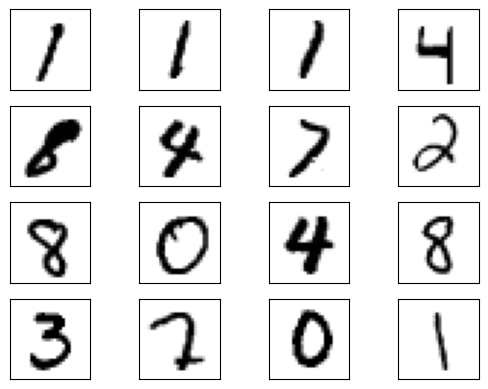

In [10]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(111)

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(10,10)
        self.model = nn.Sequential(
            nn.Linear(784 + 10, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)  
        x = torch.cat((x,self.embedding(labels)),-1)
        output = self.model(x)
        return output


discriminator = Discriminator().to(device=device)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(10,10)
        self.model = nn.Sequential(
            nn.Linear(100 + 10, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x, labels):
        input = torch.cat((x, self.embedding(labels)),-1)
        output = self.model(input)
        output = output.view(input.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)


lr = 0.0001
num_epochs = 20
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
losses = []
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        
        gen_labels = torch.randint(0,10,(batch_size,1)).flatten().to( device=device )
        
        generated_samples = generator(latent_space_samples,gen_labels)
        
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )


        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples,gen_labels)
        output_discriminator_generated = discriminator(generated_samples,gen_labels)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()


         # Training the discriminator
        mnist_labels = mnist_labels.to(device=device)
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples,torch.cat((mnist_labels,gen_labels),-1))
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        losses.append([loss_discriminator.detach().cpu(),loss_generator.detach().cpu()])
        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.48483335971832275
Epoch: 0 Loss G.: 0.534596860408783
Epoch: 1 Loss D.: 0.011578476056456566
Epoch: 1 Loss G.: 4.991677761077881
Epoch: 2 Loss D.: 0.017880018800497055
Epoch: 2 Loss G.: 6.831875801086426
Epoch: 3 Loss D.: 0.008010218851268291
Epoch: 3 Loss G.: 5.88657283782959
Epoch: 4 Loss D.: 0.030914563685655594
Epoch: 4 Loss G.: 4.410886764526367
Epoch: 5 Loss D.: 0.25678908824920654
Epoch: 5 Loss G.: 5.386086463928223
Epoch: 6 Loss D.: 0.0947825014591217
Epoch: 6 Loss G.: 2.9086570739746094
Epoch: 7 Loss D.: 0.13670915365219116
Epoch: 7 Loss G.: 2.9964938163757324
Epoch: 8 Loss D.: 0.25289446115493774
Epoch: 8 Loss G.: 3.9489951133728027
Epoch: 9 Loss D.: 0.14846383035182953
Epoch: 9 Loss G.: 2.293868064880371
Epoch: 10 Loss D.: 0.215531125664711
Epoch: 10 Loss G.: 2.3993935585021973
Epoch: 11 Loss D.: 0.27464407682418823
Epoch: 11 Loss G.: 1.7289810180664062
Epoch: 12 Loss D.: 0.48783043026924133
Epoch: 12 Loss G.: 1.5637271404266357
Epoch: 13 Loss D.: 0.43569

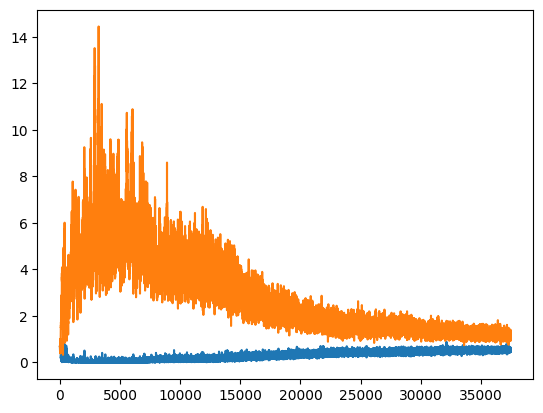

In [12]:
plt.plot(losses)

tensor([0, 2, 5, 6], device='cuda:0')


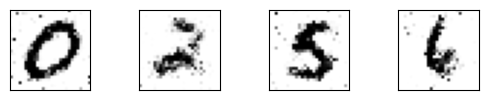

In [13]:
batch_size = 4
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
my_labels = torch.randint(0,10,(batch_size,1)).flatten().to( device=device )
# my_labels = torch.tensor([1,2,3,4]*32).to( device=device )

generated_samples = generator(latent_space_samples,my_labels)
generated_samples = generated_samples.cpu().detach()
print(my_labels)
for i in range(4):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    # plt.label(my_labels[i])